## Imports and downloads

In [1]:
!pip install pandarallel
!pip install torch
!pip install transfomers

print("\n")
print("INSTALLATIONS COMPLETE.")

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=7aed04db31d67db01fadd70203e1a750971ac20976cd6b1a66b39bb40df16c6d
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
ERROR: Could not find a version that satisfies the requirement transfomers (from versions: none)
ERROR: No matching distribution found for transfomers


INSTALLATIONS COMPLETE.


In [2]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve,f1_score
import time
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
import re


# HW2 new imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

print('Imports done.')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpor

In [3]:
electronics_dataset = pd.read_csv('../input/amazon-reviews-2018-electronics/labeled_electronics_dataset.csv')

electronics_dataset.head()

,overall,vote,reviewTime,reviewText,summary,Label
0,2,0,2010-02-10,Tech support is the worst,1265760000,NEGATIVE
1,2,0,2016-10-24,Screws were missing from the bracket and beaut...,Spend a little more and get much better.,NEGATIVE
2,1,0,2017-07-10,Trouble connecting and staying connected via b...,1499644800,NEGATIVE
3,4,5,2013-05-02,I purchased this unit for our RV to replace an...,Receiver Offers a Lot of Flexibility & Complexity,POSITIVE
4,3,0,2013-01-04,It works. Nuff said but the review requires 1...,It's a cable,NEUTRAL


## Data pre-processing

In [4]:
# Check for NaN values
print("NaN (before cleanup) ?: \n", electronics_dataset.isnull().sum())

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].fillna('')

print("NaN (after cleanup) ?: \n", electronics_dataset.isnull().sum())

NaN (before cleanup) ?: 
 overall       0
vote          0
reviewTime    0
reviewText    1
summary       0
Label         0
dtype: int64
NaN (after cleanup) ?: 
 overall       0
vote          0
reviewTime    0
reviewText    0
summary       0
Label         0
dtype: int64


In [5]:
# Text preprocessing for reviewText column
# Lower all text

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].str.lower()

# Initialize pandarallel
# I used pandarallel because it applies the functions much faster than a normal pandas apply.
pandarallel.initialize(nb_workers=4,progress_bar=True)

# Remove all special characters
def remove_special_chars(text):
    return ''.join(x if x.isalnum() else ' ' for x in text)

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(remove_special_chars)

# get stopwords.
stop_words = set(stopwords.words('english'))

# Remove stop_words
def remove_stopwords(text):
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]


electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(remove_stopwords)

# Lemmatization
def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(lemmatize_word)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

electronics_dataset['reviewText'] = electronics_dataset['reviewText'].parallel_apply(remove_numbers)

print('Example of preprocessing train: ')
print(electronics_dataset['reviewText'][0])

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Example of preprocessing train: 
tech support worst


In [6]:
X = electronics_dataset['reviewText']
y = electronics_dataset['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Create numerical labels for BERT model
train_numerical_labels = label_encoder.fit_transform(y_train)
test_numerical_labels = label_encoder.fit_transform(y_test)
print(train_numerical_labels)

[0 2 0 ... 2 1 0]


## BERT Model creation and evaluation

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3, output_attentions = False, output_hidden_states = False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Find max lengths of train and test datasets in order to use it later for BERT
max_len = 0

# Train dataset
for review in X_train:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(review, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max review length (train): ', max_len)

max_len = 0

# Test dataset
for review in X_test:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(review, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max review length (test): ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (702 > 512). Running this sequence through the model will result in indexing errors


Max review length (train):  1198
Max review length (test):  845


In [9]:
# ================== TRAIN DATASET ==================
train_input_ids = []
train_attention_masks = []

# Set the seed value to 42 in order to make experiment reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Train dataset encoding
for review in X_train:
    encoded_dict = tokenizer.encode_plus(
                        review,                      # review to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all reviews.
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True # truncate reviews to max length
                   )
    
    # Add the encoded review to the list.    
    train_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])

# Move all tensors and model to GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:1")

# Make lists into tensors
train_input_ids = torch.cat(train_input_ids, dim=0).to(device)
train_attention_masks = torch.cat(train_attention_masks, dim=0).to(device)
train_labels = torch.tensor(train_numerical_labels).to(device)



train_input_ids = train_input_ids.to(device)
train_attention_masks = train_attention_masks.to(device)
train_labels = train_labels.to(device)

train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# ================== TEST DATASET ==================
# Tokenize test data
test_input_ids = []
test_attention_masks = []

# Valid dataset encoding
for review in X_test:
    encoded_dict = tokenizer.encode_plus(
                        review,                      # review to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all reviews.
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True # truncate reviews to max length
                   )
    
    # Add the encoded review to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])


# Make lists into tensors and move them to GPU
test_input_ids = torch.cat(test_input_ids, dim=0).to(device)
test_attention_masks = torch.cat(test_attention_masks, dim=0).to(device)

# Create DataLoader for test data
test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

print("Data loading complete.")

Data loading complete.


In [16]:
learning_rate = 2e-5
num_epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

model.to(device)
training_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_predictions = []
    train_true_labels = []
    start_time = time.time()
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        train_predictions.extend(predicted_labels.tolist())
        train_true_labels.extend(labels.tolist())
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Added gradient clipping as well
        optimizer.step()
    
    train_f1 = f1_score(train_true_labels, train_predictions, average='macro')
    training_f1_scores.append(train_f1)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(train_dataloader)}")
    print("Elapsed time:", elapsed_time, "seconds")
    print("\n")

Epoch 1, Average Loss: 0.6471018642638213
Elapsed time: 1452.4111037254333 seconds


Epoch 2, Average Loss: 0.5034781448791174
Elapsed time: 1452.247225522995 seconds




In [17]:
# Test predictions
test_predictions = []

# Iterate over test set batches
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask = batch
    
    # Disable gradient calculation
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    
    # Convert predictions to CPU and append to test_predictions list
    test_predictions.extend(predictions.cpu().numpy())

# print("Test set predictions:", test_predictions)
print("Test prediction done.")

Test prediction done.


In [18]:
string_pred_preds = label_encoder.inverse_transform(test_predictions)
print(classification_report(y_test,string_pred_preds))

print("accuracy: ",accuracy_score(y_test,string_pred_preds))
print("f1: ",f1_score(y_test,string_pred_preds,average='micro'))
print("total f1: ",f1_score(y_test,string_pred_preds,average=None))

              precision    recall  f1-score   support

    NEGATIVE       0.71      0.79      0.75      1575
     NEUTRAL       0.47      0.31      0.37       808
    POSITIVE       0.73      0.77      0.75      1579

    accuracy                           0.69      3962
   macro avg       0.64      0.62      0.62      3962
weighted avg       0.67      0.69      0.67      3962

accuracy:  0.6862695608278647
f1:  0.6862695608278647
total f1:  [0.74738416 0.37247569 0.75262184]


## Evaluation methods

In [19]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test,string_pred_preds)
print(confusion_matrix(y_test,string_pred_preds))

[[1250  124  201]
 [ 317  249  242]
 [ 203  156 1220]]


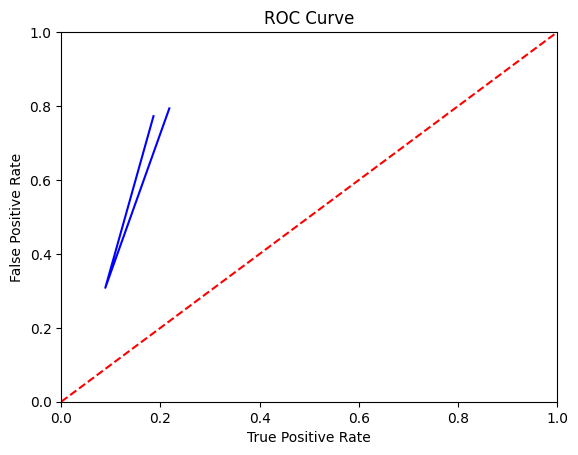

In [20]:
# ROC Curve
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix) # false positive
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix) # false negative
TP = np.diag(conf_matrix) # true positive
TN = conf_matrix.sum() - (FP + FN + TP) # True negative

TPR = TP/(TP+FN) # true positive rate
FPR = FP/(FP+TN) # false positive rate

plt.plot(FPR,TPR,'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()